In [119]:
!jupyter nbconvert Final.ipynb --to slides --post serve

[NbConvertApp] Converting notebook Final.ipynb to slides
[NbConvertApp] Writing 1797332 bytes to Final.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Final.slides.html
Use Control-C to stop this server
[NbConvertApp] WARNING | No web browser found: could not locate runnable browser.
^C

Interrupted


In [69]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import datetime
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as func
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet152
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim

from models import VGG, ResNet
from train import train1Epoch, test1Epoch
torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True
import seaborn as sns

import os
import cv2
import argparse
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from scipy.stats import pearsonr

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, RawScoresOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [2]:
torch.cuda.is_available(), torch.version.cuda

(True, '10.2')

%load_ext tensorboard
torch.backends.cudnn.benchmark = True
writer=SummaryWriter()
%tensorboard --logdir='runs/' --inspect

!start chrome http://localhost:6006/

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

!pip install https://download.pytorch.org/whl/nightly/cu117/torch-1.14.0.dev20221030%2Bcu117-cp39-cp39-linux_x86_64.whl
!pip install https://download.pytorch.org/whl/nightly/cu117/torchvision-0.15.0.dev20221030%2Bcu117-cp39-cp39-linux_x86_64.whl
torch.cuda.is_available(), torch.version.cuda

In [9]:
username = os.environ.get("JUPYTERHUB_USER")

## Quarter 1 Project
### David Davila, Marco Morocho, Yash Potdar

## Data Preprocessing

- Extracting the paths and keys for the radiographs
- Read in the train, validation, and test datasets
    - Created a label for edema (whether the BNPP value was over 400)
- Found all images that were also present in the datasets
    - 15164 train (**80.2%**), 1823 validation (**9.6%**), 1913 test (**10.1%**)

- Comparing the datasets
    - Threshold for edema: 2.6 (equates to a raw BNPP value of 400)
    - All medians above the threshold
    - Training set median > test set median by around 115
    - Training set mean > test set mean by around 85
<div>
<center>
<img src="presentation-images/DataFrame_describe_comparison.png" width="500"/>
</center>
</div>

<table><tr>
<td> <img src="presentation-images/train_set_bnpp.png" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="presentation-images/val_set_bnpp.png" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="presentation-images/test_set_bnpp.png" alt="Drawing" style="width: 250px;"/> </td>

</tr></table>

In [106]:
DATA_PATH = f"/home/{username}/teams/dsc-180a---a14-[88137]/df_bnpp_datapaths.csv"
KEY_PATH = f"/home/{username}/teams/dsc-180a---a14-[88137]/df_bnpp_keys.csv"

df_datapaths = pd.read_csv(DATA_PATH, header=None).T.merge(pd.read_csv(KEY_PATH, header=None).T, left_index=True, right_index=True)
df_datapaths.columns = ['filepaths', 'key']
df_datapaths.key = df_datapaths.key.apply(lambda x: eval(x))
df_datapaths.filepaths = df_datapaths.filepaths.apply(lambda x: eval(x))
df_datapaths = df_datapaths.set_index('key')
#missing h5py files 7-9

cols= ['unique_key', 'bnpp_value_log', 'BNP_value']
test_df = pd.read_csv(f"/home/{username}/teams/dsc-180a---a14-[88137]/BNPP_DT_test_with_ages.csv", usecols = cols).set_index('unique_key')
train_df = pd.read_csv(f"/home/{username}/teams/dsc-180a---a14-[88137]/BNPP_DT_train_with_ages.csv", usecols = cols).set_index('unique_key')
val_df = pd.read_csv(f"/home/{username}/teams/dsc-180a---a14-[88137]/BNPP_DT_val_with_ages.csv", usecols = cols).set_index('unique_key')
print(train_df.shape, test_df.shape, val_df.shape)
train_df['heart'] = train_df['BNP_value'].apply(lambda x: int(x > 400))
test_df['heart'] = test_df['BNP_value'].apply(lambda x: int(x > 400))
val_df['heart'] = val_df['BNP_value'].apply(lambda x: int(x > 400))


train_df = train_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
test_df = test_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
val_df = val_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
print(train_df.shape, test_df.shape, val_df.shape)

train_df['filepaths'] = train_df['filepaths'].str.replace('jmryan', username)
test_df['filepaths'] = test_df['filepaths'].str.replace('jmryan', username)
val_df['filepaths'] = val_df['filepaths'].str.replace('jmryan', username)
train_df.shape, test_df.shape, val_df.shape

train_df.reset_index(names='unique_key',inplace=True)
val_df.reset_index(names='unique_key',inplace=True)
test_df.reset_index(names='unique_key',inplace=True)
display(train_df.bnpp_value_log.describe(), val_df.bnpp_value_log.describe(),test_df.bnpp_value_log.describe())

train_df = train_df.to_numpy()
val_df = val_df.to_numpy()
test_df = test_df.to_numpy()

(21374, 2) (2602, 2) (2692, 2)
(15164, 4) (1823, 4) (1913, 4)


count    15164.000000
mean         2.945298
std          0.883620
min          0.690196
25%          2.247973
50%          2.971276
75%          3.603577
max          4.845099
Name: bnpp_value_log, dtype: float64

count    1913.000000
mean        2.923053
std         0.877200
min         0.690196
25%         2.232996
50%         2.940018
75%         3.577722
max         4.845099
Name: bnpp_value_log, dtype: float64

count    1823.000000
mean        2.900550
std         0.848562
min         0.690196
25%         2.231723
50%         2.913814
75%         3.528851
max         4.845099
Name: bnpp_value_log, dtype: float64

In [158]:
import seaborn as sns

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:454: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges[:-1], name="edges"),
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:455: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(np.diff(edges) * shrink, name="widths"),


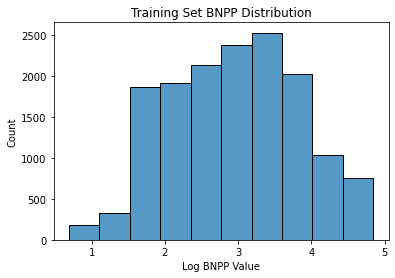

In [151]:
fig1 = sns.histplot(train_df[:, 1], bins = 10).set(title='Training Set BNPP Distribution')
plt.xlabel('Log BNPP Value');

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:454: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges[:-1], name="edges"),
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:455: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(np.diff(edges) * shrink, name="widths"),


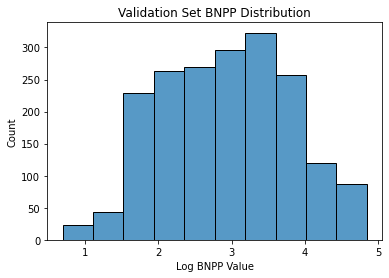

In [160]:
fig2 = sns.histplot(val_df[:, 1], bins = 10).set(title='Validation Set BNPP Distribution')
plt.xlabel('Log BNPP Value');

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:454: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges[:-1], name="edges"),
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:455: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(np.diff(edges) * shrink, name="widths"),


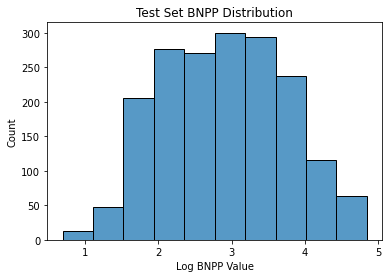

In [161]:
fig2 = sns.histplot(test_df[:, 1], bins = 10).set(title='Test Set BNPP Distribution')
plt.xlabel('Log BNPP Value');

In [123]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Loading Data

- Preprocess each value to have a 3x224x224 tensor for the image, the log BNPP value, and edema label

In [122]:
class PreprocessedImageDataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df[idx,:]
        #returns image, bnpp value log, binary variable for edema
        return torch.load(row[4]).view(1, 224, 224).expand(3, -1, -1), row[1], row[3]

In [34]:
batch_size = 32
num_workers = 4
pin_memory = True

train_set = PreprocessedImageDataset(df=train_df) #, transform = train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)#, pin_memory=pin_memory)


valid_set = PreprocessedImageDataset(df=val_df) #, transform = valid_transform)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)#, pin_memory=pin_memory)

test_set = PreprocessedImageDataset(df=test_df)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=num_workers)#, pin_memory=pin_memory)

import time
pin_memory = True
print('pin_memory is', pin_memory)
 
for num_workers in range(0, 5): 
    #train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    #sampler=train_sampler, num_workers=num_workers, pin_memory=pin_memory)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    start = time.time()
    for epoch in range(1, 3):
        for i, data in enumerate(train_loader):
            pass
    end = time.time()
    print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

### Displaying radiographs

1


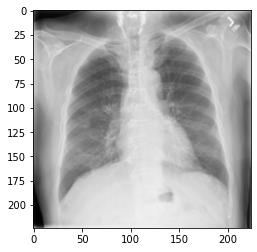

In [131]:
plt.imshow(train_set[0][0].permute(1, 2, 0),cmap='gray');
print(train_set[0][2])

1


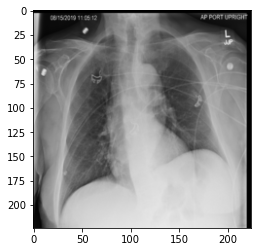

In [133]:
plt.imshow(valid_set[0][0].permute(1, 2, 0),cmap='gray');
print(valid_set[0][2])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
resnet = ResNet()
#model.classifier = nn.Linear(in_features=32768, out_features=1, bias=True)
resnet.to(device)
resnet

## Comparing Model Architectures
    
|       | ResNet152 | VGG16 |
| ----------- | ----------- | ----------- |
| Trainable parameters       | 58,145,857       | 27,514,413 |
| Loss function   | L1-loss        | L1-loss|
 |Learning rate |$10^{-4}$ |$10^{-4}$ |
 |Optimizer |Adam |Adam |
 |Epochs |15 |15 |
 |Frozen validation layers? |Yes |Yes|

In [65]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet = resnet152(pretrained=True)
resnet.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
resnet.to(device)

/home/ypotdar/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ypotdar/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /home/ypotdar/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys_r")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels, _ = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid)
print('  '.join(str('%.2f' % labels[j].item()) for j in range(batch_size)))

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

total_params = sum(p.numel() for p in resnet.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in resnet.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function, Mean Absolute Error
loss_fn = nn.L1Loss().to(device)
#loss_fn = nn.HuberLoss().to(device)
#loss_fn = nn.SmoothL1Loss().to(device)

# the optimizer
# need to tune optimizer
LR = 0.0001
RHO = 0.99
#optimizer = optim.Adadelta(model.parameters(), lr=LR)
optimizer = optim.Adam(resnet.parameters(), lr=LR)

[INFO]: Computation device: cuda
[INFO]: 58,145,857 total parameters.
[INFO]: 58,145,857 trainable parameters.


In [11]:
os.environ['NUM_GPU']='1'

In [12]:
#early stopping?
#more epochs
#save model
#print images w/ predicted/actual BNPP values
#pearson R scatterplot (predicted/actual BNPP values) 
#Docker
#run.py

epoch_number = 0

EPOCHS = 15

# the scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

tlosses, vlosses = np.array([]),np.array([])

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    for param in resnet.parameters():
        param.requires_grad = True
    avg_tloss = train1Epoch(epoch_number, resnet, optimizer, loss_fn, train_loader)#, writer)
    
    
    for param in resnet.parameters():
        param.requires_grad = False
    with torch.no_grad():
        avg_vloss = test1Epoch(epoch_number, resnet, loss_fn, valid_loader)

    print('LOSS train {} valid {}'.format(avg_tloss, avg_vloss))
    tlosses = np.append(tlosses,avg_tloss)
    vlosses = np.append(vlosses,avg_vloss)

    epoch_number += 1
    scheduler.step(avg_vloss)

EPOCH 1:


100%|██████████| 60/60 [00:06<00:00,  9.26it/s]

LOSS train 0.5717559197443218 valid 0.5720368867447286
EPOCH 2:



100%|██████████| 60/60 [00:06<00:00,  9.68it/s]


LOSS train 0.4828689713285461 valid 0.4896791239063434
EPOCH 3:


100%|██████████| 60/60 [00:05<00:00, 10.16it/s]

LOSS train 0.43130286149934044 valid 0.509975914494207
EPOCH 4:



100%|██████████| 60/60 [00:05<00:00, 10.16it/s]


LOSS train 0.38985800888389394 valid 0.4777336468583274
EPOCH 5:


100%|██████████| 60/60 [00:05<00:00, 10.27it/s]

LOSS train 0.3357629256665879 valid 0.47766061939384363
EPOCH 6:



100%|██████████| 60/60 [00:06<00:00,  9.96it/s]

LOSS train 0.30207457936989895 valid 0.4875093170977947
EPOCH 7:



100%|██████████| 60/60 [00:06<00:00,  9.69it/s]


LOSS train 0.27506817060792477 valid 0.48344846139273534
EPOCH 8:


100%|██████████| 60/60 [00:06<00:00,  9.82it/s]


LOSS train 0.2474717899704808 valid 0.48989186839470533
EPOCH 9:


100%|██████████| 60/60 [00:05<00:00, 10.09it/s]

LOSS train 0.23156113133006467 valid 0.48164402684712143
EPOCH 10:



100%|██████████| 60/60 [00:06<00:00,  9.85it/s]


LOSS train 0.22175765837882827 valid 0.4744188581029299
EPOCH 11:


100%|██████████| 60/60 [00:06<00:00,  9.77it/s]

LOSS train 0.20479082344630606 valid 0.4823472059525283
EPOCH 12:



100%|██████████| 60/60 [00:06<00:00,  9.89it/s]

LOSS train 0.19890364776409347 valid 0.47987668490813473
EPOCH 13:



100%|██████████| 60/60 [00:06<00:00,  9.91it/s]


LOSS train 0.1871099619596258 valid 0.4806267136059395
EPOCH 14:


100%|██████████| 60/60 [00:05<00:00, 10.05it/s]

LOSS train 0.17661194366261146 valid 0.47100307389265844
EPOCH 15:



100%|██████████| 60/60 [00:06<00:00,  9.79it/s]

LOSS train 0.17738931522505988 valid 0.47134919286551874


In [14]:
#loss on unseen test set
for param in resnet.parameters():
    param.requires_grad = False
with torch.no_grad():
    test_loss = test1Epoch(epoch_number, resnet, loss_fn, test_loader)
print(test_loss)

100%|██████████| 1823/1823 [00:59<00:00, 30.70it/s]

0.4728361980737522


/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


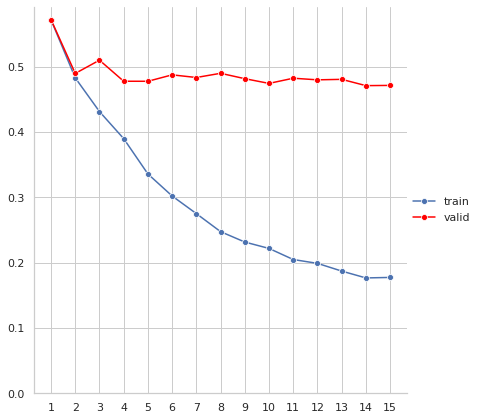

In [15]:
epochs = np.arange(1,EPOCHS+1)
df = pd.DataFrame(data={'train loss': tlosses,'valid loss':vlosses})
sns.set(style='whitegrid')
g = sns.FacetGrid(df, height = 6)
g = g.map(sns.lineplot, x=epochs,y=tlosses,marker='o', label='train loss')
g = g.map(sns.lineplot, x=epochs,y=vlosses,color='red',marker='o', label='valid loss')
g.set(ylim=(0, None))
g.add_legend()
plt.xticks(epochs)
plt.show()

### VGG SECTION

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
vgg = VGG('VGG16').to(device)

cuda


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

total_params = sum(p.numel() for p in vgg.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in vgg.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function, Mean Absolute Error
loss_fn = nn.L1Loss().to(device)

LR = 0.0001
optimizer = optim.Adam(vgg.parameters(), lr=0.0001)

[INFO]: Computation device: cuda
[INFO]: 27,514,413 total parameters.
[INFO]: 27,514,413 trainable parameters.


In [18]:
epoch_number = 0

EPOCHS = 15

# the scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

tlosses2, vlosses2 = np.array([]), np.array([])

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    for param in vgg.parameters():
        param.requires_grad = True
    avg_tloss2 = train1Epoch(epoch_number, vgg, optimizer, loss_fn, train_loader)
    
    for param in vgg.parameters():
        param.requires_grad = False
    with torch.no_grad():
        avg_vloss2 = test1Epoch(epoch_number, vgg, loss_fn, valid_loader)

    print('LOSS train {} valid {}'.format(avg_tloss2, avg_vloss2))
    tlosses2 = np.append(tlosses2,avg_tloss2)
    vlosses2 = np.append(vlosses2,avg_vloss2)

    epoch_number += 1
    scheduler.step(avg_vloss2)
    #https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/

EPOCH 1:


100%|██████████| 60/60 [00:05<00:00, 11.53it/s]

LOSS train 0.8054708609082464 valid 0.9748579933187752
EPOCH 2:



100%|██████████| 60/60 [00:04<00:00, 13.82it/s]

LOSS train 0.6622301219703404 valid 0.5828448622120042
EPOCH 3:



100%|██████████| 60/60 [00:04<00:00, 13.65it/s]

LOSS train 0.6111185776960255 valid 0.5354950892032627
EPOCH 4:



100%|██████████| 60/60 [00:04<00:00, 13.51it/s]

LOSS train 0.5920826370042428 valid 0.5292590989313547
EPOCH 5:



100%|██████████| 60/60 [00:04<00:00, 13.62it/s]

LOSS train 0.5796345114971068 valid 0.5256658447041829
EPOCH 6:



100%|██████████| 60/60 [00:04<00:00, 13.13it/s]

LOSS train 0.5668740911237026 valid 0.5294904533724519
EPOCH 7:



100%|██████████| 60/60 [00:04<00:00, 13.26it/s]

LOSS train 0.5602201316426025 valid 0.5376033978025628
EPOCH 8:



100%|██████████| 60/60 [00:04<00:00, 13.39it/s]

LOSS train 0.5517184848597696 valid 0.5699966224861829
EPOCH 9:



100%|██████████| 60/60 [00:04<00:00, 13.05it/s]

LOSS train 0.5465231760314145 valid 0.4938642520259489
EPOCH 10:



100%|██████████| 60/60 [00:04<00:00, 13.72it/s]

LOSS train 0.5387050660964093 valid 0.49986654369945377
EPOCH 11:



100%|██████████| 60/60 [00:04<00:00, 13.55it/s]

LOSS train 0.5322991762930787 valid 0.48819871639029805
EPOCH 12:



100%|██████████| 60/60 [00:04<00:00, 13.63it/s]

LOSS train 0.5290427890081223 valid 0.4949878051525405
EPOCH 13:



100%|██████████| 60/60 [00:04<00:00, 13.18it/s]

LOSS train 0.5244078617866823 valid 0.5167010935559774
EPOCH 14:



100%|██████████| 60/60 [00:04<00:00, 13.65it/s]

LOSS train 0.5202072439176221 valid 0.4911986252540327
EPOCH 15:



100%|██████████| 60/60 [00:04<00:00, 13.05it/s]

LOSS train 0.516680562866041 valid 0.5074032599073426


In [19]:
#loss on unseen test set
for param in vgg.parameters():
    param.requires_grad = False
with torch.no_grad():
    test_loss = test1Epoch(epoch_number, vgg, loss_fn, test_loader)
print(test_loss)

100%|██████████| 1823/1823 [00:16<00:00, 111.41it/s]

0.5166566595079819


/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


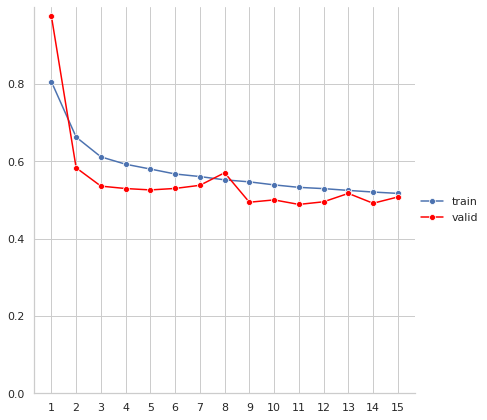

In [20]:
epochs = np.arange(1,EPOCHS+1)
df = pd.DataFrame(data={'train loss': tlosses2,'valid loss':vlosses2})
sns.set(style='whitegrid')
g = sns.FacetGrid(df, height = 6)
g = g.map(sns.lineplot, x=epochs,y=tlosses2,marker='o', label='train')
g = g.map(sns.lineplot, x=epochs,y=vlosses2,color='red',marker='o', label='valid')
g.set(ylim=(0, None))
g.add_legend()
plt.xticks(epochs)
plt.show()

## Loss Curve Comparison

/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


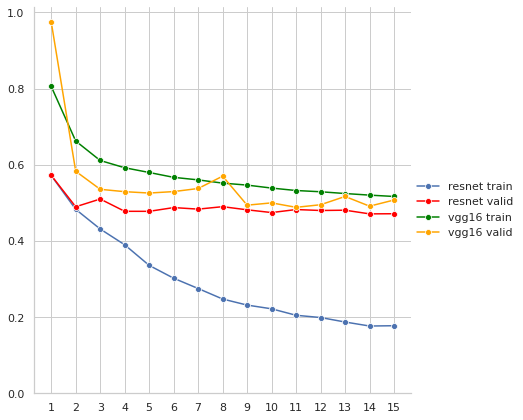

In [21]:
epochs = np.arange(1,EPOCHS+1)
df = pd.DataFrame(data={'train loss resnet': tlosses,'valid loss resnet':vlosses, 'train loss vgg': tlosses2,'valid loss vgg':vlosses2})
sns.set(style='whitegrid')
g = sns.FacetGrid(df, height = 6)
g = g.map(sns.lineplot, x=epochs,y=tlosses,marker='o', label='resnet train')
g = g.map(sns.lineplot, x=epochs,y=vlosses,color='red',marker='o', label='resnet valid')
g = g.map(sns.lineplot, x=epochs,y=tlosses2,color='green',marker='o', label='vgg16 train')
g = g.map(sns.lineplot, x=epochs,y=vlosses2,color='orange',marker='o', label='vgg16 valid')

g.set(ylim=(0, None))
g.add_legend()
plt.xticks(epochs)
plt.show()

<div>
<center>
<img src="presentation-images/LossCurves.png" width="525"/>
</center>
</div>

### Loss Curve Interpretation:
- Shows performance of both networks over 15 epochs
- ResNet has significantly lower loss over time when compared to VGG for the training set.
- ResNet seems to continue decreasing beyond 15 epochs, whereas VGG looks to plateau towards the end of 15 epochs.

## Confusion Matrix for ResNet Results

In [22]:
resnet.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds, hearts = np.array([]), np.array([])
with torch.no_grad():
        for i, (image, _, heart) in tqdm(enumerate(test_loader), total=len(test_loader)):
            image = image.to(device, non_blocking=True)
            pred = resnet(image)
            hearts = np.append(hearts, heart)
            preds = np.append(preds, pred.cpu())
prob_preds = np.power(10,preds) / (np.power(10,preds)).sum()
y_preds = prob_preds > (np.power(10,np.log10(400))/(np.power(10,preds)).sum())

100%|██████████| 1823/1823 [01:09<00:00, 26.36it/s]


accuracy score: 0.7844212835984641

TN: 495
FP: 203
FN: 190
TP: 935

Confusion matrix
[[495 203]
 [190 935]]


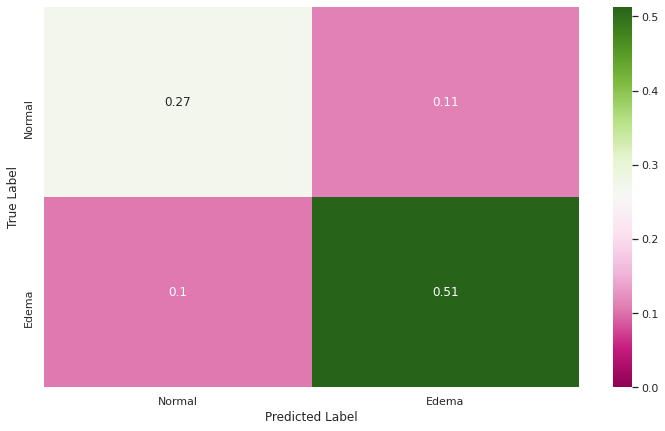

In [104]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

print(f'accuracy score: {accuracy_score(hearts, y_preds)}')
tn, fp, fn, tp = confusion_matrix(hearts, y_preds).ravel()
print(f'\nTN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}\n')
cf_mat = confusion_matrix(hearts, y_preds)
print('Confusion matrix')
df_cm = pd.DataFrame(cf_mat/np.sum(cf_mat), index = ['Normal','Edema'],
                     columns = ['Normal','Edema'])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True,vmin=0,cmap="PiYG")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
print(cf_mat)

<div>
<center>
<img src="presentation-images/ResnetAUC.png" width="850"/>
</center>
</div>

## Confusion Matrix for VGG Results

In [24]:
vgg.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds2, hearts2 = np.array([]), np.array([])
with torch.no_grad():
        for i, (image, _, heart) in tqdm(enumerate(test_loader), total=len(test_loader)):
            image = image.to(device, non_blocking=True)
            pred = vgg(image)
            hearts2 = np.append(hearts2, heart)
            preds2 = np.append(preds2, pred.cpu())
prob_preds2 = np.power(10,preds2) / (np.power(10,preds2)).sum()
y_preds2 = prob_preds2 > (np.power(10,np.log10(400))/(np.power(10,preds2)).sum())

100%|██████████| 1823/1823 [00:15<00:00, 119.53it/s]


accuracy score: 0.7745474492594624

TN: 539
FP: 159
FN: 252
TP: 873

Confusion matrix
[[539 159]
 [252 873]]


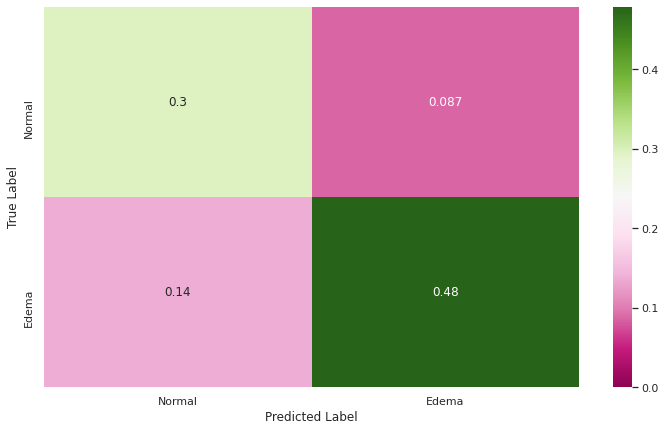

In [105]:
print(f'accuracy score: {accuracy_score(hearts2, y_preds2)}')
tn, fp, fn, tp = confusion_matrix(hearts2, y_preds2).ravel()
print(f'\nTN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}\n')
cf_mat = confusion_matrix(hearts2, y_preds2)
print('Confusion matrix')
df_cm = pd.DataFrame(cf_mat/np.sum(cf_mat), index = ['Normal','Edema'],
                     columns = ['Normal','Edema'])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True,vmin=0,cmap="PiYG")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
print(cf_mat)

<div>
<center>
<img src="presentation-images/VGGAUC.png" width="850"/>
</center>
</div>

### Combined AUC Curves

In [33]:
actuals = np.array([])
for i in np.arange(1823):
    actuals = np.append(actuals, test_set[i][1])

In [110]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    return roc_auc_score(true_y, y_prob)

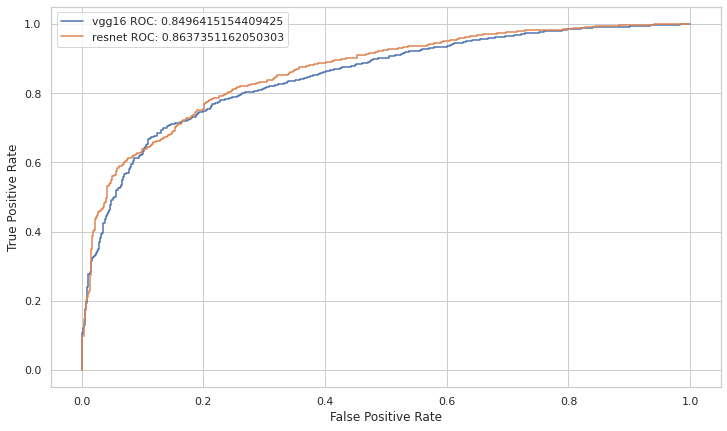

In [113]:
plt.figure(figsize = (12,7))
aucVGG = plot_roc_curve(hearts2,preds2)
aucRes = plot_roc_curve(hearts,preds)
plt.gca().legend((f'vgg16 ROC: {aucVGG}',f'resnet ROC: {aucRes}'))
plt.show()

## Interpreting AUROC
- The AUC curve shows the trade-off between true positive rate (TPR) and false positive rate (FPR)
    - As seen in the confusion matrix for VGG, the TPR contained 873 and FPR contained 159 (of 1823 occurences)
    - For ResNet, the TPR the TPR contained 935 and FPR contained 203 (of 1823 occurences)
- Plot shows ResNet has a slightly large area under the curve

## Pearson R Analysis


Scatterplots of measured BNPP laboratory values (x-axis) vs. respective predicted values (y-axis) for our ResNet152 (left) and VGG16 (right) architectures on the test set:
<table><tr>
<td> <img src="presentation-images/PearsonR_ResNet.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="presentation-images/PearsonR_VGG.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

- Pearson R values indicate a moderately positive linear relationship between measured and predicted.
    - ResNet has a slightly greater Pearson R compared to VGG
- Notice that there is a horizontal line at ~ 4.8 indicating top coded values in our dataset.
- Approximate Range of laboratory measured BNPP values: [0.5, 4.8]
- Approximate Range of predicted values: [1.2, 4.6]

In [32]:
def plot_pearson_r(y_test, y_true, color = "blue"):
    corr, _ = pearsonr(y_true, y_test)
    
    sns.scatterplot(x=y_true, y=y_test, color=color)
    plt.title('r = {}'.format(np.around(corr, 3)))

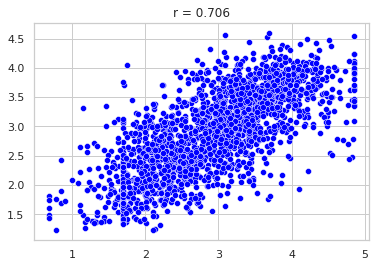

In [36]:
#Resnet Pearson R
plot_pearson_r(preds, actuals)

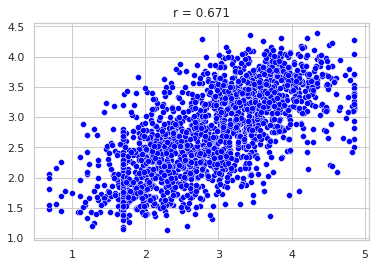

In [37]:
#VGG Pearson R
plot_pearson_r(preds2, actuals)

torch.save(model, '/home/ddavilag/private/DSC180A/DSC180A')

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn
            }, '/home/ddavilag/private/DSC180A/DSC180A/VGG16_1.pt')

#Loading the model
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# - or -
model.train()

(12, 12)


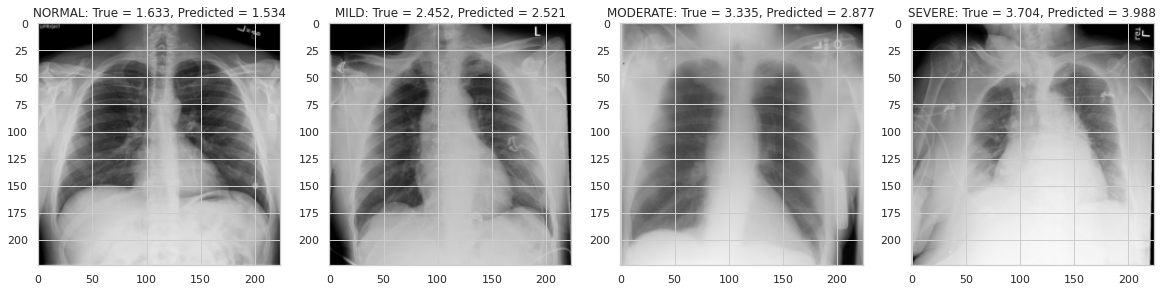

In [72]:
indices=[0, 1, 2, 3, 4]
indices = np.array(indices)
img_num = indices.size
row_num = int(np.ceil(img_num/2))
fig_size = (4 * row_num, 4 * row_num)
fig, (ax1,ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,24))
print(fig_size)

#normal
ax1.title.set_text('NORMAL: True = {:.3f}, Predicted = {:.3f}'.format(actuals[7], preds[7]))
ax1.imshow(test_set[7][0].permute(1, 2, 0),cmap='gray')

#mild
ax2.title.set_text('MILD: True = {:.3f}, Predicted = {:.3f}'.format(actuals[1], preds[1]))
ax2.imshow(test_set[1][0].permute(1, 2, 0),cmap='gray')

#moderate
ax3.title.set_text('MODERATE: True = {:.3f}, Predicted = {:.3f}'.format(actuals[0], preds[0]))
ax3.imshow(test_set[0][0].permute(1, 2, 0),cmap='gray')

#severe
ax4.title.set_text('SEVERE: True = {:.3f}, Predicted = {:.3f}'.format(actuals[23], preds[23]))
ax4.imshow(test_set[23][0].permute(1, 2, 0),cmap='gray')

plt.show()

Normal Case GradCAM


/tmp/ipykernel_118/2382801463.py:19: DeprecationWarning: ROTATE_270 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_270 instead.
  Image.fromarray(images).transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)
/tmp/ipykernel_118/2382801463.py:19: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  Image.fromarray(images).transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)


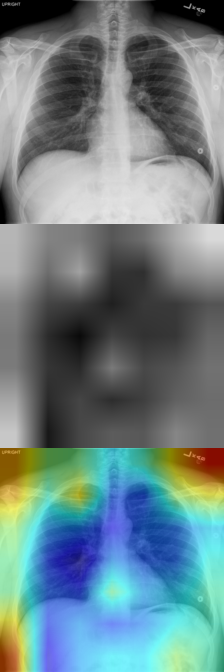

In [83]:
resnet.train()
for param in resnet.parameters():
    param.requires_grad = True
resnet.eval()
target_layers = [resnet.layer4[-1]]
input_tensor = test_set[7][0].unsqueeze(0).to(device)

targets = [RawScoresOutputTarget()]

rgb_img = np.float32((test_set[7][0]).T)
target_layers = [resnet.layer4]
with GradCAM(model=resnet, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True)#,eigen_smooth=True)
    cam_image = show_cam_on_image(rgb_img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*rgb_img), cam , cam_image))
print('Normal Case GradCAM')
Image.fromarray(images).transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)

MILD Case GradCAM


/tmp/ipykernel_118/4272892774.py:19: DeprecationWarning: ROTATE_270 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_270 instead.
  Image.fromarray(images).transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)
/tmp/ipykernel_118/4272892774.py:19: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  Image.fromarray(images).transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)


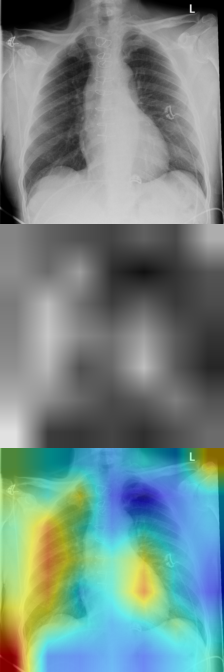

In [85]:
resnet.train()
for param in resnet.parameters():
    param.requires_grad = True
resnet.eval()
target_layers = [resnet.layer4[-1]]
input_tensor = test_set[1][0].unsqueeze(0).to(device)

targets = [RawScoresOutputTarget()]

rgb_img = np.float32((test_set[1][0]).T)
target_layers = [resnet.layer4]
with GradCAM(model=resnet, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True)#,eigen_smooth=True)
    cam_image = show_cam_on_image(rgb_img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*rgb_img), cam , cam_image))
print('MILD Case GradCAM')
Image.fromarray(images).transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)

MODERATE Case GradCAM


/tmp/ipykernel_118/4035983031.py:19: DeprecationWarning: ROTATE_270 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_270 instead.
  Image.fromarray(images).transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)
/tmp/ipykernel_118/4035983031.py:19: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  Image.fromarray(images).transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)


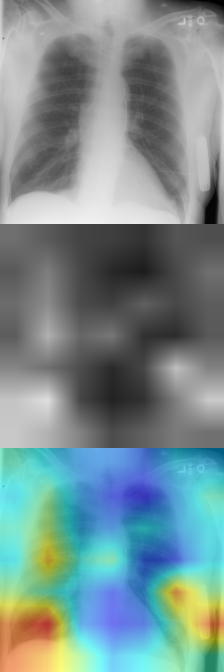

In [87]:
resnet.train()
for param in resnet.parameters():
    param.requires_grad = True
resnet.eval()
target_layers = [resnet.layer4[-1]]
input_tensor = test_set[0][0].unsqueeze(0).to(device)

targets = [RawScoresOutputTarget()]

rgb_img = np.float32((test_set[0][0]).T)
target_layers = [resnet.layer4]
with GradCAM(model=resnet, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True)#,eigen_smooth=True)
    cam_image = show_cam_on_image(rgb_img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*rgb_img), cam , cam_image))
print('MODERATE Case GradCAM')
Image.fromarray(images).transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)

SEVERE Case GradCAM


/tmp/ipykernel_118/2409582097.py:19: DeprecationWarning: ROTATE_270 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_270 instead.
  Image.fromarray(images).transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)
/tmp/ipykernel_118/2409582097.py:19: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  Image.fromarray(images).transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)


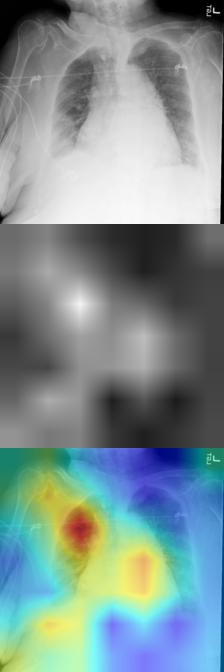

In [86]:
resnet.train()
for param in resnet.parameters():
    param.requires_grad = True
resnet.eval()
target_layers = [resnet.layer4[-1]]
input_tensor = test_set[23][0].unsqueeze(0).to(device)

targets = [RawScoresOutputTarget()]

rgb_img = np.float32((test_set[23][0]).T)
target_layers = [resnet.layer4]
with GradCAM(model=resnet, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True)#,eigen_smooth=True)
    cam_image = show_cam_on_image(rgb_img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*rgb_img), cam , cam_image))
print('SEVERE Case GradCAM')
Image.fromarray(images).transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)

## Case Examples of Different Severities of Pulmonary Edema

- Calculated Q1, median and Q3 for the test set.
- We used these values to determine the cutoffs for pulmonary edema severity (Normal, Mild, Moderate, Severe)
- Predictions determined from ResNet152

In [68]:
print("Q1 of arr : ", np.quantile(actuals, .25))
print("Median of arr : ", np.quantile(actuals, .50))
print("Q3 of arr : ", np.quantile(actuals, .75))

Q1 of arr :  2.2317225158852136
Median of arr :  2.9138138523837163
Q3 of arr :  3.5288510770898203


| Severity Level     | Range |
| ----------- | ----------- |
| Normal      |  < 2.23   | 
| Mild   | 2.23 - 2.91        |
 |Moderate | 2.91 - 3.53 |
 |Severe |> 3.53 |
 
<br>
 

<div>
<center>
<img src="presentation-images/Predictions4Images.png" width="1000"/>
</center>
</div>

## Grad-CAM Implementation for ResNet

In [ ]:
resnet.train()
for param in resnet.parameters():
    param.requires_grad = True
resnet.eval()
target_layers = [resnet.layer4[-1]]
input_tensor = test_set[7][0].unsqueeze(0).to(device)

targets = [RawScoresOutputTarget()]

rgb_img = np.float32((test_set[7][0]).T)
target_layers = [resnet.layer4]
with GradCAM(model=resnet, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True)#,eigen_smooth=True)
    cam_image = show_cam_on_image(rgb_img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*rgb_img), cam , cam_image))
print('Normal Case GradCAM')
Image.fromarray(images).transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)

## Case Examples by Severity of Pulmonary Edema
<div>
<center>
<img src="presentation-images/GradCam_Output.png" width="800"/>
</center>
</div>

## Thank you!
### Any Questions?